In [1]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib notebook

# Create custom enviroment

Environment where ball and agent are randomly put into square grid. Ball color and grid size can be changed.

In [34]:
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=5, ball_color="green"):
        self.ball_color = ball_color
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True

        return obs, reward, done, info

In [35]:
# Function to create the environment (needed for vectorized environment object in training process)
def make_env(ball_color, room_size, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = ImgObsWrapper(RGBImgPartialObsWrapper(EmptyBallRoom(size=16, ball_color=ball_color)))
        #env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [20]:
BALL_COLOR = "green"
ROOM_SIZE = 16

# Reinforcment learning

### Training first agent (not essential to use the trained agent)

In [21]:
# Number of "cores" to use
N_CPU = 12

In [22]:
# Create vectorized environment to make learning faster
env = SubprocVecEnv([make_env(ball_color = BALL_COLOR, room_size=ROOM_SIZE, rank=i*2) for i in range(N_CPU)])

In [ ]:
# Activation function to be used in CNN layers
policy_kwargs = dict(activation_fn=nn.ReLU)

In [ ]:
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html?highlight=PPO
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1)

In [ ]:
model.learn(total_timesteps=2_500_000)

In [ ]:
model.save("rgb_ball_agent")

### Loading trained agent

In [103]:
# To load zip file just enter the file name without the file type in the end
model = PPO.load("rgb_ball_agent", device="cpu")

# Displaying the agent in the enivronment

In [167]:
def display_agent(env,  pov="agent", n_eval=10):
    # Two picturs. Left side = agent's view, right side = whoel environment
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5));

    for i in range(n_eval):
        state = env.reset()
        
        print(env.ball.__dict__)
        if i == 0:
            image1 = ax1.imshow(state)              
            image2 = ax2.imshow(env.render("rgb_array"))
            
        else:
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
        while True:
            action, _ = model.predict(state)
            state, r, done, _ = env.step(action)
            image1.set_data(state)
            image2.set_data(env.render("rgb_array"))
    
            ax1.set_title(f"Action = {action}")
            ax2.set_title(f"Action = {action}")
            fig.canvas.draw()
            if done:
                break

In [104]:
# Make testing environment. Don't use previous vectorized environment (for me it freezed the notebook)
test_env = make_env(ball_color = "yellow", room_size=20, rank=5)()

In [162]:
display_agent(test_env)

# 2nd agent

This requires to change our environment. Because stable_baselines3 gets the action indeices from the environment. Look at:
https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L629

https://github.com/maximecb/gym-minigrid/blob/1d4edcfd585f6b627ebf1cfd54ea5e70260fa1ee/gym_minigrid/minigrid.py#L1099
I think redefining the Actions class and step function should be sufficient.
Possible way is to inherit EmptyBallRoom class because it has correct reward function.

In [146]:
class HackedBallRoom(MiniGridEnv):
    # Variation of ball environment which uses actions.toggle to switch the ball color
    
    def __init__(self, size=5, ball_color="green", og_model=None):
        self.ball_color = ball_color
        self.og_model = og_model
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
        
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        self.place_obj(self.ball)
        
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
    def switch_ball_color(self):
        
        if self.ball_color == "red":
            self.ball_color = "blue"
        elif self.ball_color == "blue":
            self.ball_color = "purple"
        elif self.ball_color == "purple":
            self.ball_color = "yellow"
        elif self.ball_color == "yellow":
            self.ball_color = "green"
        elif self.ball_color == "green":
            self.ball_color = "red"
    
    def step(self, action):

        if action == self.actions.toggle:
            print("ACTION - TOGGLE")
            self.step_count += 1

            reward = 0
            done = False
            
            if self.step_count >= self.max_steps:
                done = True

            # get ball current pos and switch it with a new ball
            x, y = self.ball.cur_pos
            
            self.switch_ball_color()
            self.ball = Ball(self.ball_color)
            
            self.put_obj(self.ball, x, y)
            #self.place_obj(self.ball)
            self.mission = f"Pick up {self.ball_color} {self.ball.type}"
        
            obs = self.gen_obs()

            return obs, reward, done, {}
        else:
            obs, reward, done, info = super().step(action)

            if action == self.actions.pickup:
                if self.carrying and self.carrying == self.ball:
                    reward = self._reward()
                    done = True

            return obs, reward, done, info

        

In [147]:
def make_hacked_env(ball_color, room_size, og_model, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = ImgObsWrapper(RGBImgPartialObsWrapper(HackedBallRoom(size=room_size, ball_color=ball_color, og_model=og_model)))
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [148]:
og_model = PPO.load("rgb_ball_agent", device="cpu")
# Create vectorized environment to make learning faster
env = SubprocVecEnv([make_hacked_env(ball_color = "blue", room_size=8, og_model=og_model, rank=i*2) for i in range(N_CPU)])

# Activation function to be used in CNN layers
policy_kwargs = dict(activation_fn=nn.ReLU)

# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html?highlight=PPO
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1)

model.learn(total_timesteps=250_000)

model.save("rgb_hacked_ball_agent")

Using cpu device
Wrapping the env in a VecTransposeImage.
------------------------------
| time/              |       |
|    fps             | 1737  |
|    iterations      | 1     |
|    time_elapsed    | 14    |
|    total_timesteps | 24576 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 303       |
|    iterations           | 2         |
|    time_elapsed         | 162       |
|    total_timesteps      | 49152     |
| train/                  |           |
|    approx_kl            | 0.0137549 |
|    clip_fraction        | 0.107     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.94     |
|    explained_variance   | -0.105    |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0242   |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 0.0101    |
---------------------------------------
-----

In [ ]:
model = PPO.load("rgb_hacked_ball_agent", device="cpu")

<IPython.core.display.Javascript object>


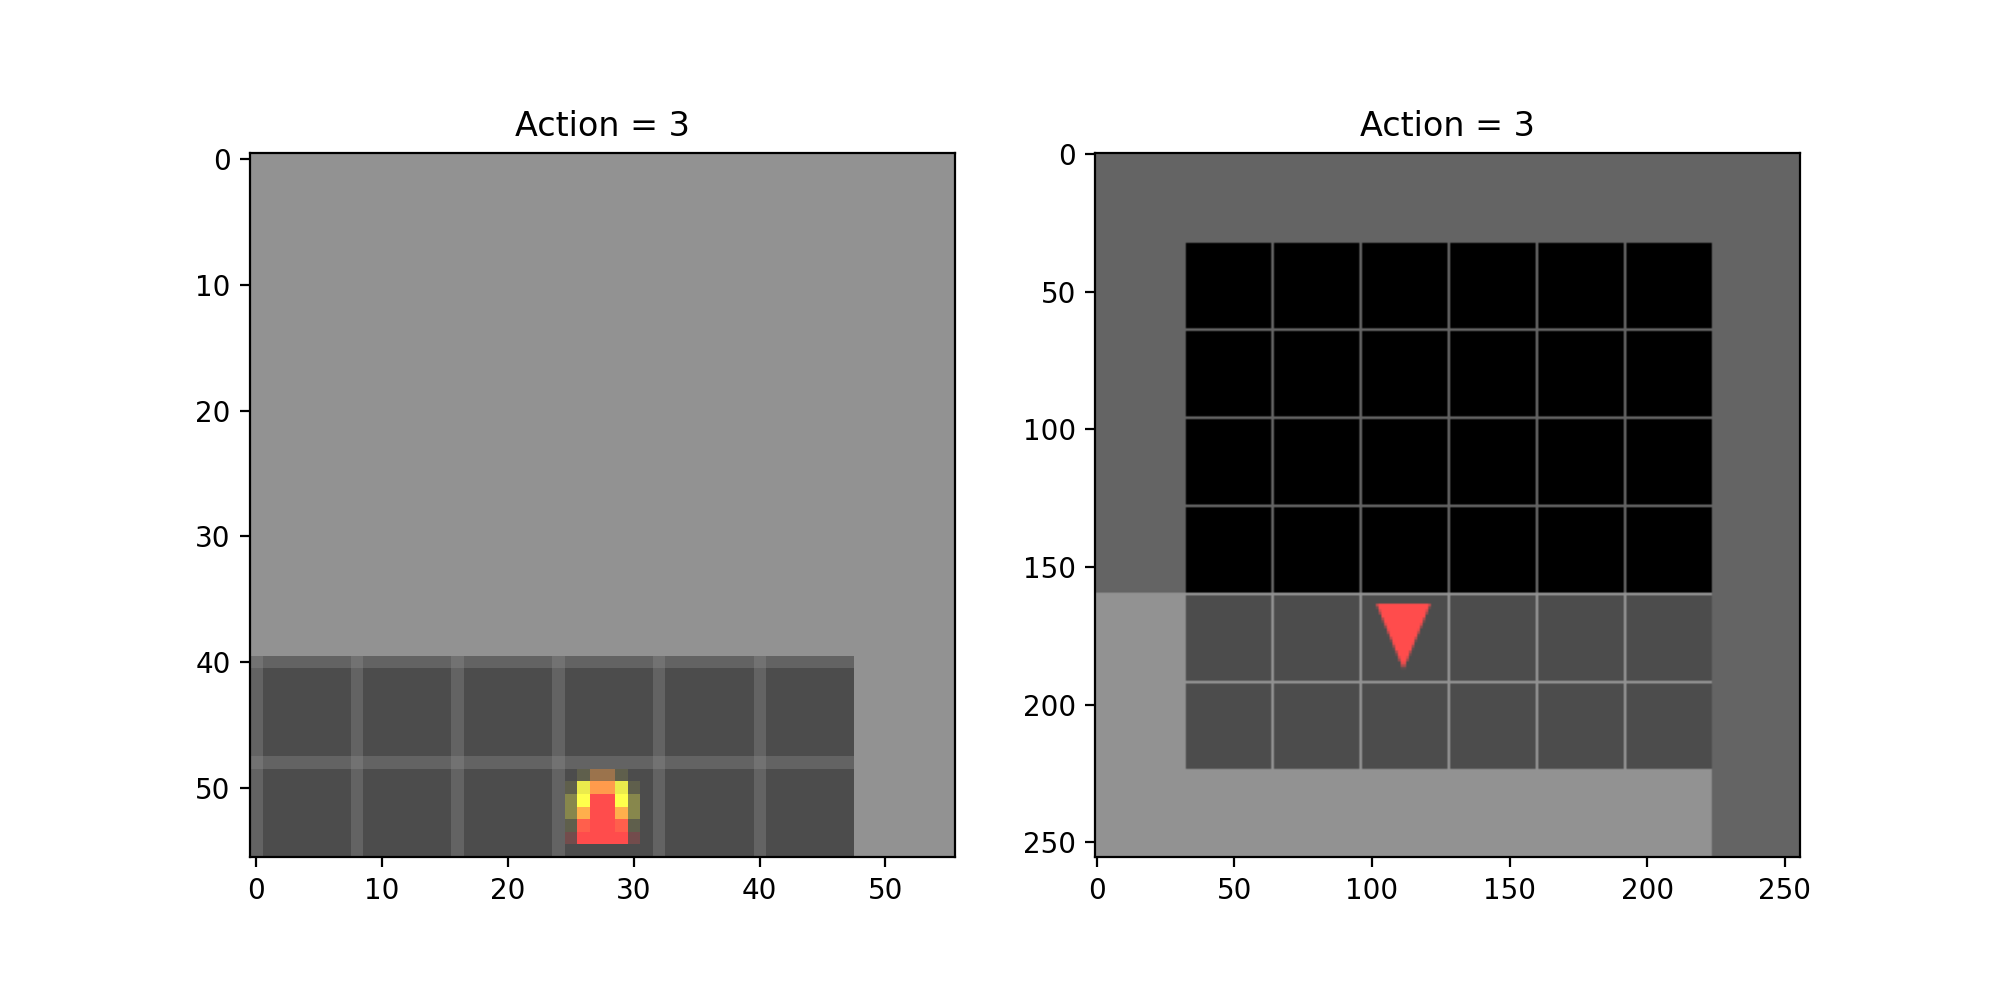

{'type': 'ball', 'color': 'blue', 'contains': None, 'init_pos': array([2, 5]), 'cur_pos': array([2, 5])}
ACTION - TOGGLE
{'type': 'ball', 'color': 'purple', 'contains': None, 'init_pos': array([4, 1]), 'cur_pos': array([4, 1])}
{'type': 'ball', 'color': 'purple', 'contains': None, 'init_pos': array([3, 4]), 'cur_pos': array([3, 4])}
ACTION - TOGGLE
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([4, 5]), 'cur_pos': array([4, 5])}
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([3, 5]), 'cur_pos': array([3, 5])}
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([1, 2]), 'cur_pos': array([1, 2])}
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([1, 5]), 'cur_pos': array([1, 5])}
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([2, 3]), 'cur_pos': array([2, 3])}
{'type': 'ball', 'color': 'yellow', 'contains': None, 'init_pos': array([5, 4]), 'cur_pos': array([5, 4])}
{'type'

In [168]:
test = make_hacked_env(ball_color = "blue", room_size=8, rank=5, og_model=og_model)()
display_agent(test)
# TODO investigate why env.reset() in display_agent() doesn't reset the ball color

# but overall the hack seems to work, the agent changes the color 2 times until the ball is yellow 
# and then it can find it easily